# Coursera Capstone Project Report: an insight on neighborhood types in New York City based on their most prevalent venue categories

## Introduction and business problem
The 2020 Global Cities index firmly positions New York City (NYC) as the top global metropolis, remaining unchanged in this position from the previous year ranking (source: https://www.kearney.com/global-cities/2020). Therefore, as a global city, NYC is a prime location for new startup businesses. However, lease space in global cities is limited and expensive, so prospective business owners should use quality data to inform their venue-opening decisions according to their needs. This report attempts to provide guidance by offering a segmentation of the neighborhoods in NYC based on their venue composition. A prospective entrepreneur should leverage this information to make a business decision that optimizes resources.

The present document is thus specifically meant for entrepreneurs looking to open a business in the city of New York. The data analyses done here address the question: Which type of neighborhood should I choose to open my business? In order to provide a recommendation, the data analyses offer a machine learning-based segmentation of neighborhoods into two main categories based on their most prevalent types of venues and services. Information on said venues and services was collected for every neighborhood of NYC using the Foursquare service. Readers are encouraged to use this information to prioritize their buying or leasing decisions.

Please note that an analysis of the property prices per neighborhood is not in the scope of this document. It is expected that, after identifying their preferred type of neighborhood based on venue composition, prospective business owners should seek additional data sources to identify their most cost-effective solution.

## Data
The data on this report comes from two main sources: one of them is a dataset that offers a breakdown of boroughs and neighborhoods of NYC, with coordinates information. This dataset is offered by IBM and was used previously on the capstone course. The main purpose of this dataset is to categorize NYC into its component neighborhoods in order to access venue data for each of these locations.

The second source of data consists of information on venues obtained through Foursquare. All neighborhoods were queried, and 100 venues on a 500 m radius were fetched. Data was grouped at the neighborhood level, and for each neighborhood a list with all venue categories present on that neighborhood was generated. Said categories were used to train a K-means clustering algorithm, setting the number of clusters to 5. Of those clusters, only two consisted of more than two neighborhoods, so those were used for further analysis. On these two clusters, the mode for each of the top 10 most common venue categories per neighborhood was obtained, and the categories were used to describe each cluster in terms of three descriptors: food venues, stores, and transportation services.

Overall, the clustering process revealed two very distinct categories in terms of their most common service types. These findings will be discussed in detail in the final version of this report, to be delivered on the final week of the capstone project.

### Data analysis section
This section is devoted to the data treatment, which has already been done in this version of the report. Discussion, deep-dive analysis, conclusions, and recommendations will be included in the final version of this report, to be delivered in the final week of the capstone course. Therefore, please regard this part of the report as a work in progress.

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

In [2]:
# Get New York dataset from IBM
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json

In [3]:
# Load json file
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
# The relevant data is in the features key (list of neighborhoods)
neighborhoods_data = newyork_data['features']

In [5]:
# Transform into pandas dataframe. First create an empty dataframe just with column names
columns = ['borough', 'neighborhood', 'latitude', 'longitude']
df = pd.DataFrame(columns=columns)

In [6]:
# Add data from the json file
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough']
    neighborhood_name = data['properties']['name']
    
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df = df.append({'borough': borough, 'neighborhood': neighborhood_name,
                    'latitude': neighborhood_lat, 'longitude': neighborhood_lon}, ignore_index=True)

In [7]:
# Check the dataframe
df.head()

,borough,neighborhood,latitude,longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
# Query shape
df.shape

(306, 4)

In [9]:
# Check how many boroughs there are in New York
df['borough'].value_counts()

Queens           81
Brooklyn         70
Staten Island    63
Bronx            52
Manhattan        40
Name: borough, dtype: int64

In [10]:
# Get the coordinates of NYC
address = 'New York City, NY'
geolocator = Nominatim(user_agent='ny_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [11]:
# Check
(latitude, longitude)

(40.7127281, -74.0060152)

In [12]:
# Create a map of NYC with neighborhoods superimposed
map_nyc = folium.Map(location=[latitude,longitude],zoom_start=10)

# markers
for lat, lng, borough, neighborhood in zip(df['latitude'],df['longitude'], 
                                           df['borough'], df['neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,lng], radius=5, popup=label, color='blue',
                       fill=True, fill_color='#3186cc', fill_opacity=0.7,
                       parse_html=False).add_to(map_nyc)

In [13]:
# Display map
map_nyc

In [14]:
# Neighborhoods will be clustered using K-means scoring according to venues fetched from foursquare  
# For foursquare, setting a radius of 500 m and a limit of 100 
client_id = 'removed - sensitive information'
client_secret = 'removed - sensitive information'
access_token = 'removed - sensitive information'
version = '20180605'
limit = 100
radius= 500

In [15]:
# Split the neighborhood data into lists to use in a for loop
names = df['neighborhood']
latitudes = df['latitude']
longitudes = df['longitude']

In [16]:
# Function that loops over each neighborhood, sends a foursquare request, and gets venues
def getnearbyvenues(names, latitudes, longitudes):
    venues_list=[]
    
    # Looping through each neighborhood
    for name, lat, lng, in zip(names, latitudes, longitudes):
        
        # API request
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(client_id,
                                                                                                                           client_secret,lat,
                                                                                                                           lng,version,radius,
                                                                                                                           limit)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # Paste the venue data into the previously-initialized list
        venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in results])
    
    # Once the loop is finished grab all the data and put it into a dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighborhood', 'neighborhood latitude',
                            'neighborhood longitude', 'venue',
                            'venue latitude', 'venue longitude', 'venue category']
    
    # Return the dataframe
    return nearby_venues

In [17]:
nyc_venues = getnearbyvenues(names, latitudes, longitudes)

In [18]:
# Quick view of the data and shape of the dataframe
nyc_venues

,neighborhood,neighborhood latitude,neighborhood longitude,venue,venue latitude,venue longitude,venue category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place
4,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
...,...,...,...,...,...,...,...
9496,Queensbridge,40.756091,-73.945631,Track 114,40.753008,-73.947833,Platform
9497,Fox Hills,40.617311,-74.081740,SUBWAY,40.618939,-74.082881,Sandwich Place
9498,Fox Hills,40.617311,-74.081740,MTA Bus - Targee St & Vanderbilt Av (S74/S76),40.614856,-74.084598,Bus Stop
9499,Fox Hills,40.617311,-74.081740,Bottomley's,40.616581,-74.086632,Bar


In [19]:
# Check for repeats. One would expect that big brand names are repeated many times over across the city
nyc_venues['venue'].value_counts()

Dunkin'                      158
Chase Bank                   111
Subway                        82
T-Mobile                      67
Rite Aid                      53
                            ... 
Gaetana's Cucina Italiana      1
Sprintpcs Store                1
Smith & Vine                   1
Schmul Park                    1
Rejuvenate                     1
Name: venue, Length: 7190, dtype: int64

In [20]:
# See the number of venues per neighborhood
grouptab = nyc_venues.groupby('neighborhood').count()
grouptab[['venue']]

,venue
neighborhood,
Allerton,33
Annadale,13
Arden Heights,6
Arlington,4
Arrochar,19
...,...
Woodhaven,24
Woodlawn,27
Woodrow,19


In [21]:
# The shape of this dataframe gives us the total number of neighborhoods
grouptab.shape

(301, 6)

In [22]:
# Per neighborhood analysis with onehot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['venue category']], prefix='', prefix_sep='')

nyc_onehot['neighborhood'] = nyc_venues['neighborhood']

fixed_columns = [nyc_onehot.columns[-1]]+list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

In [23]:
nyc_onehot.head()

,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio
0,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Group the onehot dataframe by neighborhood
nyc_onehot_grp = nyc_onehot.groupby('neighborhood').mean().reset_index()

In [25]:
nyc_onehot_grp.head()

,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio
0,Allerton,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
# Dataframe with top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} most common venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th most common venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = nyc_onehot_grp['neighborhood']

for ind in np.arange(nyc_onehot_grp.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_onehot_grp.iloc[ind, :], 
                                                                          num_top_venues)

neighborhoods_venues_sorted.head()

,neighborhood,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
0,Allerton,Deli / Bodega,Pizza Place,Supermarket,Spa,Chinese Restaurant,Pharmacy,Discount Store,Fast Food Restaurant,Playground,Department Store
1,Annadale,Pizza Place,Restaurant,Liquor Store,Diner,Dance Studio,Pharmacy,Food,Park,Train Station,Bakery
2,Arden Heights,Coffee Shop,Bus Stop,Pharmacy,Pizza Place,Home Service,Deli / Bodega,Other Repair Shop,Other Nightlife,Piano Bar,Photography Studio
3,Arlington,Boat or Ferry,Deli / Bodega,Bus Stop,Grocery Store,Paper / Office Supplies Store,Pharmacy,Pet Store,Pet Service,Pet Café,Peruvian Restaurant
4,Arrochar,Pizza Place,Italian Restaurant,Bus Stop,Pharmacy,Food Truck,Polish Restaurant,Nail Salon,Hotel,Sandwich Place,Cosmetics Shop


In [28]:
# Visualize the shape of the above dataframe
neighborhoods_venues_sorted.shape

(301, 11)

In [29]:
# A K-means model will be trained below, using k = 5

# Select number of clusters for neighborhoods
kclusters = 5

# Prepare a new dataframe for model fitting
nyc_grp_clust = nyc_onehot_grp.drop('neighborhood',1)

In [30]:
nyc_grp_clust.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Fit the model
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grp_clust)

In [32]:
# Check the first ten labels
kmeans.labels_[0:10]

array([2, 2, 0, 0, 2, 2, 2, 2, 2, 2], dtype=int32)

In [33]:
# Check the number of labels
kmeans.labels_.size

301

In [34]:
# Paste those cluster labels into a new dataframe
neighborhoods_venues_sorted.insert(0,  'cluster labels', kmeans.labels_)
df_nyc_merged = df
df_nyc_merged = df_nyc_merged.join(neighborhoods_venues_sorted.set_index('neighborhood'), on='neighborhood')

In [35]:
# Drop NaN values
df_nyc_merged_dropna = df_nyc_merged.dropna()

In [36]:
# Typeset cluster labels as integers
df_nyc_merged_dropna['cluster labels'] = df_nyc_merged_dropna['cluster labels'].astype(int)

<ipython-input-36-ad5d93895af9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc_merged_dropna['cluster labels'] = df_nyc_merged_dropna['cluster labels'].astype(int)


In [37]:
# Check the updated dataframe 
df_nyc_merged_dropna.head()

,borough,neighborhood,latitude,longitude,cluster labels,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
0,Bronx,Wakefield,40.894705,-73.847201,2,Pharmacy,Dessert Shop,Donut Shop,Ice Cream Shop,Caribbean Restaurant,Sandwich Place,Deli / Bodega,Laundromat,Outdoor Sculpture,Piano Bar
1,Bronx,Co-op City,40.874294,-73.829939,2,Bus Station,Liquor Store,Grocery Store,Park,Fried Chicken Joint,Pharmacy,Fast Food Restaurant,Basketball Court,Pizza Place,Post Office
2,Bronx,Eastchester,40.887556,-73.827806,2,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Convenience Store,Bakery,Automotive Shop,Seafood Restaurant,Chinese Restaurant,Fast Food Restaurant
3,Bronx,Fieldston,40.895437,-73.905643,2,River,Bus Station,Plaza,Music Venue,Accessories Store,Paper / Office Supplies Store,Pet Store,Pet Service,Pet Café,Peruvian Restaurant
4,Bronx,Riverdale,40.890834,-73.912585,2,Bus Station,Food Truck,Baseball Field,Home Service,Bank,Gym,Park,Accessories Store,Pet Store,Pet Service


In [38]:
# Check how many neighborhoods in each cluster
df_nyc_merged_dropna['cluster labels'].value_counts()

2    284
0     16
1      2
3      2
4      1
Name: cluster labels, dtype: int64

In [39]:
# Visualize clusters in the map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Markers
markers_colors = []
for lat, lon, poi, cluster in zip(df_nyc_merged_dropna['latitude'], 
                                  df_nyc_merged_dropna['longitude'],
                                  df_nyc_merged_dropna['neighborhood'], 
                                  df_nyc_merged_dropna['cluster labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=label,
    color=rainbow[cluster-1],
    fill=True,
    fill_color=rainbow[cluster-1],
    fill_opacity=0.7).add_to(map_clusters)

In [40]:
# Render map
map_clusters

In [41]:
# Separate each cluster into its own dataframe
df_cluster_0 = df_nyc_merged_dropna.where(df_nyc_merged_dropna['cluster labels'] == 0).dropna()
df_cluster_1 = df_nyc_merged_dropna.where(df_nyc_merged_dropna['cluster labels'] == 1).dropna()
df_cluster_2 = df_nyc_merged_dropna.where(df_nyc_merged_dropna['cluster labels'] == 2).dropna()
df_cluster_3 = df_nyc_merged_dropna.where(df_nyc_merged_dropna['cluster labels'] == 3).dropna()
df_cluster_4 = df_nyc_merged_dropna.where(df_nyc_merged_dropna['cluster labels'] == 4).dropna()

In [42]:
# Visualize each
df_cluster_0

,borough,neighborhood,latitude,longitude,cluster labels,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
193,Queens,Brookville,40.660003,-73.751753,0.0,Deli / Bodega,Piano Bar,Pharmacy,Pet Store,Pet Service,Pet Café,Peruvian Restaurant,Persian Restaurant,Perfume Shop,Performing Arts Venue
198,Staten Island,New Brighton,40.640615,-74.087017,0.0,Bus Stop,Deli / Bodega,Park,Discount Store,Laundromat,Bowling Alley,Playground,Accessories Store,Persian Restaurant,Performing Arts Venue
202,Staten Island,Grymes Hill,40.624185,-74.087248,0.0,Bus Stop,Dog Run,Accessories Store,Paper / Office Supplies Store,Pharmacy,Pet Store,Pet Service,Pet Café,Peruvian Restaurant,Persian Restaurant
204,Staten Island,South Beach,40.580247,-74.079553,0.0,Pier,Beach,Bus Stop,Deli / Bodega,Theme Park,Athletics & Sports,Accessories Store,Pedestrian Plaza,Pharmacy,Pet Store
206,Staten Island,Mariner's Harbor,40.632546,-74.150085,0.0,Deli / Bodega,Supermarket,Bus Stop,Italian Restaurant,Paper / Office Supplies Store,Pharmacy,Pet Store,Pet Service,Pet Café,Peruvian Restaurant
217,Staten Island,Tottenville,40.505334,-74.246569,0.0,Deli / Bodega,Mexican Restaurant,Bus Stop,Cosmetics Shop,Italian Restaurant,Thrift / Vintage Store,Accessories Store,Peruvian Restaurant,Performing Arts Venue,Perfume Shop
224,Staten Island,Park Hill,40.609190,-74.080157,0.0,Athletics & Sports,Bus Stop,Hotel,Coffee Shop,Accessories Store,Photography Studio,Pharmacy,Pet Store,Pet Service,Pet Café
226,Staten Island,Graniteville,40.620172,-74.153152,0.0,Boat or Ferry,Bus Stop,Grocery Store,Food Truck,Pakistani Restaurant,Pet Service,Pet Café,Peruvian Restaurant,Persian Restaurant,Perfume Shop
227,Staten Island,Arlington,40.635325,-74.165104,0.0,Boat or Ferry,Deli / Bodega,Bus Stop,Grocery Store,Paper / Office Supplies Store,Pharmacy,Pet Store,Pet Service,Pet Café,Peruvian Restaurant
241,Staten Island,Arden Heights,40.549286,-74.185887,0.0,Coffee Shop,Bus Stop,Pharmacy,Pizza Place,Home Service,Deli / Bodega,Other Repair Shop,Other Nightlife,Piano Bar,Photography Studio


In [43]:
df_cluster_0.shape

(16, 15)

In [44]:
df_cluster_1

,borough,neighborhood,latitude,longitude,cluster labels,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
192,Queens,Somerville,40.597711,-73.796648,1.0,Park,Accessories Store,Photography Studio,Pet Store,Pet Service,Pet Café,Peruvian Restaurant,Persian Restaurant,Perfume Shop,Performing Arts Venue
203,Staten Island,Todt Hill,40.597069,-74.111329,1.0,Trail,Park,Pakistani Restaurant,Pharmacy,Pet Store,Pet Service,Pet Café,Peruvian Restaurant,Persian Restaurant,Perfume Shop


In [45]:
df_cluster_2

,borough,neighborhood,latitude,longitude,cluster labels,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
0,Bronx,Wakefield,40.894705,-73.847201,2.0,Pharmacy,Dessert Shop,Donut Shop,Ice Cream Shop,Caribbean Restaurant,Sandwich Place,Deli / Bodega,Laundromat,Outdoor Sculpture,Piano Bar
1,Bronx,Co-op City,40.874294,-73.829939,2.0,Bus Station,Liquor Store,Grocery Store,Park,Fried Chicken Joint,Pharmacy,Fast Food Restaurant,Basketball Court,Pizza Place,Post Office
2,Bronx,Eastchester,40.887556,-73.827806,2.0,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Convenience Store,Bakery,Automotive Shop,Seafood Restaurant,Chinese Restaurant,Fast Food Restaurant
3,Bronx,Fieldston,40.895437,-73.905643,2.0,River,Bus Station,Plaza,Music Venue,Accessories Store,Paper / Office Supplies Store,Pet Store,Pet Service,Pet Café,Peruvian Restaurant
4,Bronx,Riverdale,40.890834,-73.912585,2.0,Bus Station,Food Truck,Baseball Field,Home Service,Bank,Gym,Park,Accessories Store,Pet Store,Pet Service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,Bronx,Kingsbridge Heights,40.870392,-73.901523,2.0,Bus Station,Pizza Place,Coffee Shop,Grocery Store,Chinese Restaurant,Food Truck,Bus Stop,Café,Park,Spanish Restaurant
300,Brooklyn,Erasmus,40.646926,-73.948177,2.0,Caribbean Restaurant,Pharmacy,Food Truck,Health Food Store,Fast Food Restaurant,Mobile Phone Shop,Pizza Place,Bank,Chinese Restaurant,Ice Cream Shop
301,Manhattan,Hudson Yards,40.756658,-74.000111,2.0,American Restaurant,Gym / Fitness Center,Hotel,Coffee Shop,Italian Restaurant,Park,Burger Joint,Restaurant,Gym,Music School
302,Queens,Hammels,40.587338,-73.805530,2.0,Beach,Gym / Fitness Center,Fast Food Restaurant,Shoe Store,Food Truck,Fried Chicken Joint,Neighborhood,Bus Station,Dog Run,Diner


In [46]:
df_cluster_3

,borough,neighborhood,latitude,longitude,cluster labels,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
76,Brooklyn,Mill Island,40.606336,-73.908186,3.0,Pool,Accessories Store,Pakistani Restaurant,Pet Store,Pet Service,Pet Café,Peruvian Restaurant,Persian Restaurant,Perfume Shop,Performing Arts Venue
238,Staten Island,Butler Manor,40.506082,-74.229504,3.0,Baseball Field,Pool,Gas Station,Pakistani Restaurant,Pet Store,Pet Service,Pet Café,Peruvian Restaurant,Persian Restaurant,Perfume Shop


In [47]:
df_cluster_4

,borough,neighborhood,latitude,longitude,cluster labels,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
303,Queens,Bayswater,40.611322,-73.765968,4.0,Playground,Accessories Store,Pakistani Restaurant,Pet Store,Pet Service,Pet Café,Peruvian Restaurant,Persian Restaurant,Perfume Shop,Performing Arts Venue


In [48]:
# Clusters 0 and 2 are much larger than 1, 2, and 4, so the analysis will focus on contrasting clusters 0 and
# 2. 1, 2 and 4 will be treated as outlier neighborhoods, as they comprise only 5 neighborhoods.

In [49]:
# Zip the dataframes into a list
dflist = [df_cluster_0, df_cluster_2]

In [50]:
# Define a function that takes a dataframe and gets the mode for each of the top 10 most common venue columns
def getvenues(df):
    listclust = []
    for a,b,c,d,e,f,g,h,i,j in zip(df['1st most common venue'].mode(), df['2nd most common venue'].mode(),
              df['3rd most common venue'].mode(), df['4th most common venue'].mode(),
              df['5th most common venue'].mode(), df['6th most common venue'].mode(),
              df['7th most common venue'].mode(), df['8th most common venue'].mode(),
              df['9th most common venue'].mode(), df['10th most common venue'].mode()):
        listclust.append(a)
        listclust.append(b)
        listclust.append(c)
        listclust.append(d)
        listclust.append(e)
        listclust.append(f)
        listclust.append(g)
        listclust.append(h)
        listclust.append(i)
        listclust.append(j)
        
    return listclust

In [51]:
# Run the function on both dataframes of interest
d0,d2 = [getvenues(x) for x in dflist]

In [52]:
(len(d0), len(d2))

(10, 10)

In [53]:
# Create a dataframe with the modes
popular_venues_0_2 = pd.DataFrame({'cluster 0': d0, 'cluster 2': d2})

In [54]:
popular_venues_0_2

,cluster 0,cluster 2
0,Bus Stop,Pizza Place
1,Bus Stop,Pizza Place
2,Bus Stop,Pizza Place
3,Accessories Store,Ice Cream Shop
4,Paper / Office Supplies Store,Pizza Place
5,Pet Store,Pizza Place
6,Pet Service,Pet Store
7,Pet Café,Bakery
8,Pet Café,Chinese Restaurant
9,Perfume Shop,Pharmacy


In [55]:
# Create a dictionary for manual counting of the data above. We'll call cluster 0 "Cluster A", and cluster 2
# "Cluster B"
counts = {'labels': ['Food', 'Shops', 'Transportation'],
          'cluster A': [2, 5, 3], 'cluster B': [8, 2, 0]}

In [56]:
# Weld the dictionary into a dataframe
categories = pd.DataFrame(counts)

In [57]:
# Visualize the dataframe
categories

,labels,cluster A,cluster B
0,Food,2,8
1,Shops,5,2
2,Transportation,3,0


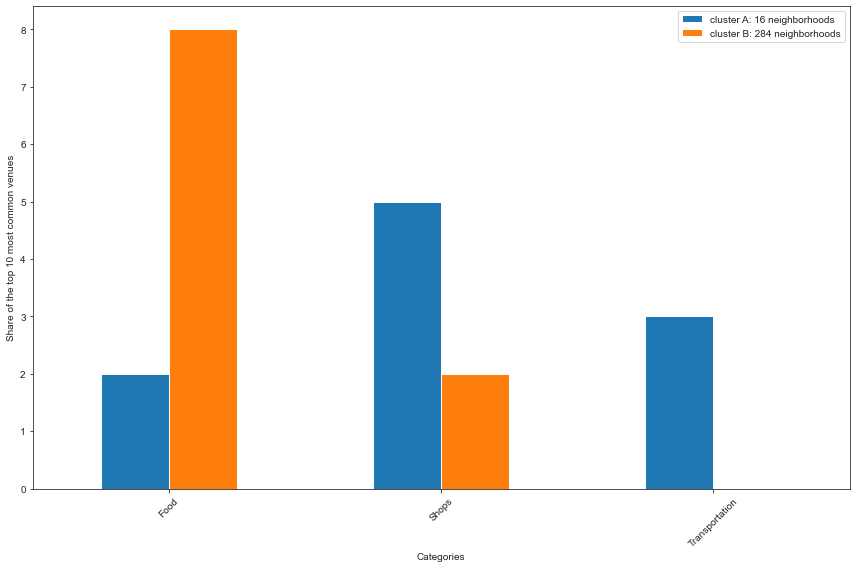

In [58]:
# Generate a bar chart
%matplotlib inline
import matplotlib.pyplot as plt
categories.plot(x='labels', 
                y=['cluster A', 'cluster B'], 
                kind='bar', figsize = (12,8));
plt.xticks(rotation=45);
plt.xlabel('Categories')
plt.ylabel('Share of the top 10 most common venues')
plt.legend(['cluster A: 16 neighborhoods', 'cluster B: 284 neighborhoods']);
plt.tight_layout();